## Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches, ticker
import seaborn as sns
import os
import geopandas
import cartopy.crs as ccrs
import cartopy
import numpy as np
import shapely
import statsmodels.api as sma
import math
import scipy

## Paths

In [2]:
WILDCARDS = ["all", "chromosome", "full", "30"]


READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

project_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/denmark/"
results_dir = project_dir
metadata_dir = os.path.join(project_dir, "metadata", "{}".format(READS_ORIGIN) )

archaeology_path    = project_dir + "metadata/{}/metadata_archaeology.txt".format(READS_ORIGIN)
beast_log_path      = project_dir + "beast/{}/chromosome/full/filter{}/relaxed_clock/dates/run/beast_log.tsv".format(READS_ORIGIN, MISSING_DATA)
out_dir             = project_dir + "beast/{}/chromosome/full/filter{}/relaxed_clock/dates/run/".format(READS_ORIGIN, MISSING_DATA)

CURRENT_YEAR = 2021
BURNIN = 0.1

# ------------------------------------------
# Geo
CRS = "epsg:3857"
#CRS_EPSG = ccrs.epsg('3857')
#world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

pd.set_option("display.max_rows", 10, "display.max_columns", None)

np.random.seed(1235423134)

NO_DATA_CHAR = "NA"
ALPHA = 0.05

# ------------------------------------------
# Geo
CRS = "epsg:3857"
CRS_EPSG = ccrs.epsg('3857')
world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# ------------------------------------------
# Plotting
plt.rcParams['axes.facecolor']    ='white'
plt.rcParams['savefig.facecolor'] ='white'
plt.rcParams['savefig.dpi']       = 400
plt.rcParams['svg.fonttype']      = 'none'

---
# Archaeology

In [29]:
archaeology_df = pd.read_csv(archaeology_path, sep="\t", encoding="latin-1")
archaeology_df.fillna("NA", inplace=True)

date_cols = ["Jesper Finalized", "Julia Adjustments - Jesper to review", "Individual date range"]

min_date = 1000
max_date = 1800
bin_width = 50
num_bins = int((max_date - min_date) / bin_width)
bin_breaks = np.linspace(min_date, max_date, num_bins + 1)

# Convert dates
for rec in archaeology_df.iterrows():
    sample = rec[0]
    #print(rec[1]["Laboratory ID"])
    i = 0
    date_str = rec[1][date_cols[i]]
    
    while "-" not in date_str:
        i += 1
        date_str = rec[1][date_cols[i]]
        
        
        
    date_list = date_str.replace("AD","").replace(" ","").split("-")
    date_list = [int(d) for d in date_list]
    
    if date_list[0] < min_date:       
        archaeology_df.drop(sample, inplace=True)
    elif date_list[1] > max_date:
        archaeology_df.drop(sample, inplace=True)        
        
    else:    
        archaeology_df.at[sample,"start_date"] = date_list[0]
        archaeology_df.at[sample,"end_date"] = date_list[1]
        archaeology_df.at[sample,"mean_date"] = (date_list[1] + date_list[0]) / 2
    
    
archaeology_df.sort_values("start_date", inplace=True)
#archaeology_df = archaeology_df[90:100]
print("Samples:", len(archaeology_df))
display(archaeology_df)


Samples: 298


,Laboratory ID,Individual ID,Element Used,Country,Province,Municipality,Cemetery,Cemetery/phase date range,Site code,Time Point,Arm Position,Dating technique,Individual date range,Julia Adjustments - Jesper to review,Jesper Finalized,Included in analyses,cMYC copies per uL (avg),pla Positive PCR Replicates,Plague Status,Mean Mitochondrial Coverage,Mitochondrial Haplotype,start_date,end_date,mean_date
0,LD52,Gr FO x241,Tooth,Denmark,Central Denmark Region,Viborg Municipality,Faldborg,1100-1555 AD,VSM 29F,Pre-BD,Pre (A),Arm position,1100-1350,1000 - 1250 AD,1000 - 1250 AD,Plague PCR detection,NA,NA,NA,NA,NA,1000.0,1250.0,1125.0
1,LR20,Gr HF 287,Tooth,Denmark,Central Denmark Region,Viborg Municipality,Faldborg,1100-1555 AD,VSM 29F,Pre-BD,Pre (AA),Arm position,1100-1350 AD,1000 - 1250 AD,1000 - 1250 AD,Plague PCR detection,NA,1,NA,--,--,1000.0,1250.0,1125.0
22,LP150,V,Tooth,Denmark,Central Denmark Region,Aarhus Municipality,Nordby,1050-1250 AD,FHM 3970,Pre-BD,Before,Cemetery Dating,1050-1250 AD,1050-1250 AD,1050-1250 AD,"GWAS, exon, neutral, Plague PCR Detection",20.5,NA,NA,H1bd,174,1050.0,1250.0,1150.0
23,LP151,EB,Tooth,Denmark,Central Denmark Region,Aarhus Municipality,Nordby,1050-1250 AD,FHM 3970,Pre-BD,Before,Cemetery Dating,1050-1250 AD,1050-1250 AD,1050-1250 AD,"GWAS, neutral, Plague PCR detection",85.8,NA,NA,H3g1a,219,1050.0,1250.0,1150.0
24,LP152,GL,Tooth,Denmark,Central Denmark Region,Aarhus Municipality,Nordby,1050-1250 AD,FHM 3970,Pre-BD,Pre,Cemetery Dating,1050-1250 AD,1050-1250 AD,1050-1250 AD,Plague PCR detection,NA,1,NA,NA,NA,1050.0,1250.0,1150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,LD16,A2549 x2598,Tooth,Denmark,Central Denmark Region,Horsens Municipality,Klosterkirken,1535-1856 AD,HOM 1272,Post-BD,Post-Medeival,Burial Type / Goods,1535-1856 AD,1750 - 1800 AD,1600 - 1800,Plague PCR Detection,NA,NA,NA,NA,NA,1600.0,1800.0,1700.0
267,LD17,A2552 x2605,Tooth,Denmark,Central Denmark Region,Horsens Municipality,Klosterkirken,1535-1856 AD,HOM 1272,Post-BD,Post-Medeival,Burial Type / Goods,1535-1856 AD,1750 - 1800 AD,1600 - 1800,Plague PCR Detection,NA,NA,NA,H5b1,44,1600.0,1800.0,1700.0
269,LD19,A2721 x2838,Tooth,Denmark,Central Denmark Region,Horsens Municipality,Klosterkirken,1535-1856 AD,HOM 1272,Post-BD,Post-Medieval,Burial Type / Goods,1535-1856 AD,1750 - 1800 AD,1600 - 1800,Plague PCR Detection,NA,NA,NA,K2b1a4,253,1600.0,1800.0,1700.0
257,LD100,A2669 x2770,Tooth,Denmark,Central Denmark Region,Horsens Municipality,Klosterkirken,1535-1856 AD,HOM 1272,Post-BD,Post-Medieval,Burial Type / Goods,1535-1856 AD,1750 - 1800 AD,1600 - 1800,"GWAS, exon, neutral, Plague PCR Detection",30.2,NA,NA,U4a2,437,1600.0,1800.0,1700.0


## Individual Date Distribution

Mean date

<built-in function bin>
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/denmark/metadata/all/timeline_individuals_mean


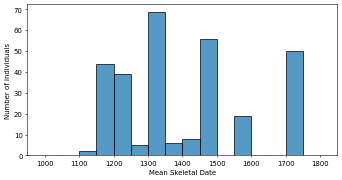

In [69]:
DPI=50
FIGSIZE=[8,4]

## All
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE, dpi=DPI)

bin_width = 50
num_bins = int((max_date - min_date) / bin_width)
bin_breaks = np.linspace(min_date, max_date, num_bins + 1)

print(bin)
sns.histplot(
    ax=ax,
    data=archaeology_df,
    x="mean_date",
    bins=bin_breaks,
)

# sns.histplot(
#     ax=ax,
#     data=archaeology_df,
#     x="start_date",
#     #color="white",
#     #edgecolor=None,
#     alpha=0,
#     bins=bin_breaks,
#     kde=True,
#     kde_kws=dict(bw_adjust=0.3),
#     line_kws=dict(color="red"),
#     fill=True,
# )

# sns.histplot(
#     ax=ax,
#     data=archaeology_df,
#     x="end_date",
#     color="green",
#     bins=bin_breaks,
# )

#for patch in ax.patches:
#    patch.set_width(10)


ax.set_xlim(min_date - bin_width, max_date + bin_width)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(bin_width))
ax.xaxis.set_major_locator(ticker.MultipleLocator(bin_width * 2))
ax.set_xlabel("Mean Skeletal Date")
ax.set_ylabel("Number of Individuals")

out_path = os.path.join(metadata_dir, "timeline_individuals_mean")
print(out_path)
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Individual Date Distribution

Maximum Number of Individuals binned by 50 years

{1000: {'n': 2, 'plague_positive': 0}, 1050: {'n': 38, 'plague_positive': 0}, 1100: {'n': 78, 'plague_positive': 1}, 1150: {'n': 89, 'plague_positive': 2}, 1200: {'n': 104, 'plague_positive': 3}, 1250: {'n': 165, 'plague_positive': 4}, 1300: {'n': 115, 'plague_positive': 3}, 1350: {'n': 91, 'plague_positive': 3}, 1400: {'n': 139, 'plague_positive': 9}, 1450: {'n': 91, 'plague_positive': 10}, 1500: {'n': 86, 'plague_positive': 9}, 1550: {'n': 33, 'plague_positive': 2}, 1600: {'n': 69, 'plague_positive': 0}, 1650: {'n': 69, 'plague_positive': 0}, 1700: {'n': 69, 'plague_positive': 0}, 1750: {'n': 50, 'plague_positive': 0}, 1800: {'n': 50, 'plague_positive': 0}}
/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/denmark/metadata/all/timeline_individuals_interval


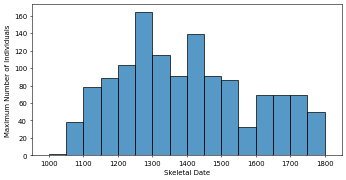

In [71]:
date_dict = {}


start_dates = [int(d) for d in archaeology_df["start_date"]]
end_dates = [int(d) for d in archaeology_df["end_date"]]
plague_statuses = [status for status in archaeology_df["Plague Status"]]

for start,end,status in zip(start_dates, end_dates, plague_statuses):
    # Round start_date down to nearest 50
    # Round end_date up to nearest 50
    start = start - (start % 50)
    end = end + 50 - (end % 50)
    # Have to add extra bin because range is not inclusive
    dates = range(start, end, bin_width)
    for d in dates:
        if d not in date_dict:
            date_dict[d] = {"n": 1, "plague_positive": 0}
        else:
            date_dict[d]["n"] += 1
        if status == "Positive":
            date_dict[d]["plague_positive"] += 1
        


# Adjust all but first date, remove last date
new_date_dict = {}
print(date_dict)

for d in date_dict.keys():
    if d == min(date_dict.keys()):
        new_date_dict[d] = date_dict[d]
    elif d == max(date_dict.keys()):
        continue
    else: 
        new_date_dict[d + 1] = date_dict[d]
        
date_dict = new_date_dict
#print(date_dict)


date_data = []
for k,v in date_dict.items():
    date_data += [k] * v["n"]
    
DPI=50
FIGSIZE=[8,4]

## All
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE, dpi=DPI)


sns.histplot(
    ax=ax,    
    x=date_data,
    bins=bin_breaks,
    #discrete=True,
)

#for patch in ax.patches:
#    patch.set_width(10)


ax.set_xlim(min_date - bin_width, max_date + bin_width)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(bin_width))
ax.xaxis.set_major_locator(ticker.MultipleLocator(bin_width * 2))
ax.set_xlabel("Skeletal Date")
ax.set_ylabel("Maximum Number of Individuals")

# Save
out_path = os.path.join(metadata_dir, "timeline_individuals_interval")
print(out_path)
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Date Categories

In [ ]:
date_cat_dict = {
    "1000-1300": {
        "start":1000,
        "end":1299,
        "n":0,
        "plague-positive":0,
    },
    "1300-1650": {
        "start":1300,
        "end":1649,
        "n":0,
        "plague-positive":0,        
    },
    "1650-1800": {
        "start":1650,
        "end":1800,
        "n":0,
        "plague-positive":0,        
    },    
}

for start,end,status in zip(start_dates, end_dates, plague_statuses):
    for cat in date_cat_dict:
        if (start >= date_cat_dict[cat]["start"]
            and end <= date_cat_dict[cat]["end"]):            
            date_cat_dict[cat]["n"] += 1
            if status != NO_DATA_CHAR:
                date_cat_dict[cat]["plague-positive"] += 1 

print(date_cat_dict)

### Tip Dates

---
# BEAST Prior

In [ ]:
mu = 1330
sigma = 115
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

DPI=50
FIGSIZE=[8,4]

## All
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE, dpi=DPI)
#print(scipy.stats.norm.pdf(x, mu, sigma))
"""ax.plot(
    x, 
    scipy.stats.norm.pdf(x, mu, sigma),
)"""


sns.lineplot(
    ax=ax,
    x=x,
    y=scipy.stats.norm.pdf(x, mu, sigma),
    lw=2,
)

x=mu-2*sigma
ylim = ax.get_ylim()

ax.axvline(x=x, ls="--", color="grey", label="2 sigma")
ax.annotate(str(x),(x*0.99, ylim[1] * 0.95), ha="right")

x=mu+2*sigma
ax.axvline(x=x, ls="--", color="grey")
ax.annotate(str(x),(x*1.01, ylim[1] * 0.95), ha="left")

# Save
out_path = os.path.join(metadata_dir, "prior_denmark")
print(out_path)
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")